# Importing and Ingesting Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ibm_boto3
from ibm_botocore.client import Config
from scipy import stats
import xgboost as xgb

We will now download the data from the link given. Then the data will be read into a pandas DataFrame.The cell below is only needed to run if the DataFrame is not in the cloud storage object. We will work with two datasets, the first one contains all the complaints directed to the Department of Housing Preservation and Development of New York, and the second is the Primary Land Use Tax Lot Output (PLUTO) dataset of housing of New York's boroughs.

In [2]:
# @hidden_cell
client = ibm_boto3.client(service_name='s3',
ibm_api_key_id="F-Fig3aoSsMES7KeqhKs9QVBUtIg8e9QVn2h4acCDgdX",
ibm_auth_endpoint='https://iam.bluemix.net/oidc/token',
config=Config(signature_version='oauth'),
endpoint_url='https://s3-api.us-geo.objectstorage.softlayer.net')
bucket = "bucket-bucket-bucket"

In [3]:
#!wget -O hpd.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0720EN-SkillsNetwork/labs/Module%201/data/311_Service_Requests_from_2010_to_Present_min.csv
#hpd_df = pd.read_csv('hpd.csv')
#hpd_df.to_pickle('./hdp_raw_pickle.pkl')
#client_cred.upload_file('./hdp_raw_pickle.pkl',bucket,'hdp_pickle.pkl')

All the DataFrames will be imported from the storage.

In [4]:
client.download_file(Bucket=bucket,Key='hdp_pickle.pkl',Filename='./hpd_raw_pickle.pkl')
hpd_df = pd.read_pickle('./hpd_raw_pickle.pkl')

client.download_file(Bucket=bucket,Key='BK_18v1.csv',Filename='BK_18v1.csv')
client.download_file(Bucket=bucket,Key='BX_18v1.csv',Filename='BX_18v1.csv')
client.download_file(Bucket=bucket,Key='MN_18v1.csv',Filename='MN_18v1.csv')
client.download_file(Bucket=bucket,Key='QN_18v1.csv',Filename='QN_18v1.csv')
client.download_file(Bucket=bucket,Key='SI_18v1.csv',Filename='SI_18v1.csv')
BK_df = pd.read_csv('BK_18v1.csv')
BX_df = pd.read_csv('BX_18v1.csv')
MN_df = pd.read_csv('MN_18v1.csv')
QN_df = pd.read_csv('QN_18v1.csv')
SI_df = pd.read_csv('SI_18v1.csv')


/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (19,20,22,23,24,25,26,64,65,80) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (19,20,22,23,64,65,80) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (20,23,24,26,64) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (19,20,22,23,64,65,77) have mixed types. Specify dtype 

This DataFrame will be loaded into our cloud storage as a pickle (.pkl) file.

In [5]:
valid_ZC_BX = np.sum(np.invert(np.isnan(pd.unique(BX_df['ZipCode']))))
valid_ZC_QN = np.sum(np.invert(np.isnan(pd.unique(QN_df['ZipCode']))))
print('Valid Zip Codes in Bronx df:',valid_ZC_BX)
print('Valid Zip Codes in Queens df:',valid_ZC_QN)

Valid Zip Codes in Bronx df: 26
Valid Zip Codes in Queens df: 65


In [6]:
hpd_df.head()

,Unique Key,Created Date,Closed Date,Complaint Type,Location Type,Incident Zip,Incident Address,Street Name,Address Type,City,Status,Resolution Description,Borough,Latitude,Longitude
0,45531130,02/02/2020 06:09:17 AM,NaN,HEAT/HOT WATER,RESIDENTIAL BUILDING,10019.0,426 WEST 52 STREET,WEST 52 STREET,ADDRESS,NEW YORK,Open,The following complaint conditions are still o...,MANHATTAN,40.765132,-73.988993
1,45529784,02/02/2020 02:15:24 PM,NaN,UNSANITARY CONDITION,RESIDENTIAL BUILDING,11204.0,1751 67 STREET,67 STREET,ADDRESS,BROOKLYN,Open,The following complaint conditions are still o...,BROOKLYN,40.618484,-73.992673
2,45527528,02/02/2020 02:27:41 AM,NaN,HEAT/HOT WATER,RESIDENTIAL BUILDING,11372.0,87-15 37 AVENUE,37 AVENUE,ADDRESS,Jackson Heights,Open,The following complaint conditions are still o...,QUEENS,40.750269,-73.879432
3,45530329,02/02/2020 12:13:18 PM,NaN,HEAT/HOT WATER,RESIDENTIAL BUILDING,10458.0,2405 SOUTHERN BOULEVARD,SOUTHERN BOULEVARD,ADDRESS,BRONX,Open,The following complaint conditions are still o...,BRONX,40.853773,-73.881558
4,45528814,02/02/2020 01:59:44 PM,NaN,APPLIANCE,RESIDENTIAL BUILDING,11209.0,223 78 STREET,78 STREET,ADDRESS,BROOKLYN,Open,The following complaint conditions are still o...,BROOKLYN,40.629745,-74.030533


# Data Wrangling

We will estimate how many reports have a missing incident address. Then we will find the most common complaint type so we can focus on those, because the idea is to help the Department of Housing Preservation and Develpment to tackle where there are the most amount of complaints. We will also drop all of the complaints that do not contain an address, because the idea is to use the address to link the properties of the housing to the number of complaints. To do this we will group the complaints dataset by it's address and then add a row of complaints to the PLUTO data set. Afterwards we will grab only the features we will look at from the PLUTO data set. Then add the a column with the number of complaints per address.

In [7]:
hpd_df['Incident Address'].isnull().sum()

52825

In [8]:
len(hpd_df['Complaint Type'].unique())

30

In [74]:
complaintsCounts = hpd_df['Complaint Type'].value_counts()
topComplaintsCounts = complaintsCounts[complaintsCounts > 900000]
print('The top complaint type:',complaintsCounts.index[0])

The top complaint type: HEAT/HOT WATER


In [76]:
topComplaints = hpd_df[hpd_df['Complaint Type'] == complaintsCounts.index[0]]
print('Number of Complaints including NaN\'s', topComplaints.shape[0])
topComplaints  = topComplaints.dropna(subset= ['Incident Address'])
print('Number of Complaints after dropping NaN\'s', topComplaints.shape[0])

Number of Complaints including NaN's 1261574
Number of Complaints after dropping NaN's 1261574


In [53]:
print('The borough with most complaints',topComplaints['Borough'].value_counts().index[0])
print('The borough with least complaints',topComplaints['Borough'].value_counts().index[-1])
print('The Zip Code with most complaints', topComplaints['Incident Zip'].value_counts().index[0])
print('The Adress with most complaints', topComplaints['Incident Address'].value_counts().index[0])
print('The ammouns of closed complaints',topComplaints['Closed Date'].notnull().sum())

The borough with most complaints BRONX
The borough with least complaints Unspecified
The Zip Code with most complaints 11226.0
The Adress with most complaints 89-21 ELMHURST AVENUE
The ammouns of closed complaints 1256876


In [54]:
BK_df = BK_df[['Address', 'BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR', 'FacilFAR', 'Lot', 'LotArea', 'LotDepth', 'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea', 'ResidFAR', 'RetailArea', 'YearBuilt', 'YearAlter1', 'ZipCode', 'YCoord','XCoord']]
BX_df = BX_df[['Address', 'BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR', 'FacilFAR', 'Lot', 'LotArea', 'LotDepth', 'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea', 'ResidFAR', 'RetailArea', 'YearBuilt', 'YearAlter1', 'ZipCode', 'YCoord','XCoord']]
MN_df = MN_df[['Address', 'BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR', 'FacilFAR', 'Lot', 'LotArea', 'LotDepth', 'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea', 'ResidFAR', 'RetailArea', 'YearBuilt', 'YearAlter1', 'ZipCode', 'YCoord','XCoord']]
QN_df = QN_df[['Address', 'BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR', 'FacilFAR', 'Lot', 'LotArea', 'LotDepth', 'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea', 'ResidFAR', 'RetailArea', 'YearBuilt', 'YearAlter1', 'ZipCode', 'YCoord','XCoord']]
SI_df = SI_df[['Address', 'BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR', 'FacilFAR', 'Lot', 'LotArea', 'LotDepth', 'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea', 'ResidFAR', 'RetailArea', 'YearBuilt', 'YearAlter1', 'ZipCode', 'YCoord','XCoord']]

In [66]:
topComplaintsBX = topComplaints[topComplaints['Borough'] == 'BRONX']
addressComplaintsBX = pd.DataFrame(topComplaintsBX['Incident Address'].value_counts())
addressComplaintsBX.rename({'Incident Address':'NumComplaints'},axis=1,inplace=True)
addressComplaintsBX[['Address']] = pd.DataFrame(addressComplaintsBX.index.to_series())
addressComplaintsBX.head()
X = pd.merge(left = BX_df, right = addressComplaintsBX, on = 'Address')
addressComplaintsBX.shape

(18993, 2)

# Exploratory Data Analysis

Now, we will look at the correlation between the features and the number of complaints (NumComplaints). Then we will choose the top correlations and plot them in a scatter plot against the number of complaints to see what typo of correlation they have. 

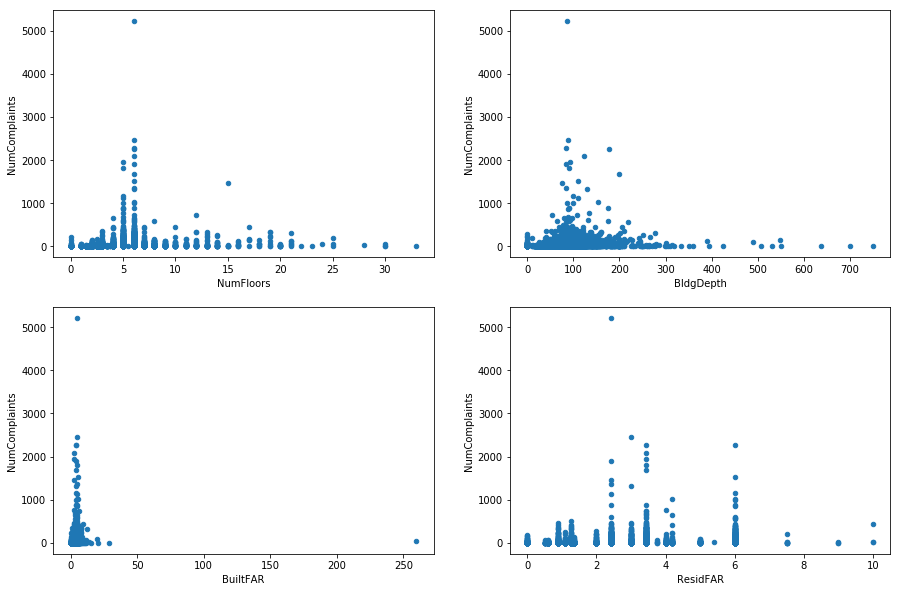

,NumComplaints
NumFloors,0.217522
BldgDepth,0.176494
BuiltFAR,0.136604
ResidFAR,0.136189


In [56]:
featuresCorr = X.corr()[['NumComplaints']].sort_values('NumComplaints', ascending = False).drop('NumComplaints')

features = featuresCorr.head(4).index.to_list()

%matplotlib inline
fig = plt.figure()
axList = []
for i, feat in enumerate(features):
    axList.append(fig.add_subplot(2,2,i+1))
    X.plot(kind='scatter', x = feat, y = 'NumComplaints', ax = axList[i], figsize = (15,10))

plt.show()
featuresCorr.head(4)    
    

# Model Development and Evaluation

It is clear from the scatter plots that there is no clear correlation between the features and the number of complaints. But for the sake of developing a model to predict the number of complaints, then a model will be trained to demonstrate how a linear model will be built and tested. On the other hand, a more realistic model will be built to predict the probability whether or not a house will generate a complaint.

In [57]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

lm = LinearRegression()
scoresLm = cross_val_score(lm, X[['NumFloors']],X[['NumComplaints']], cv=5)
print('The score for the Linear Model is :', scoresLm.mean())

The score for the Linear Model is : 0.025652797079369606


The model suggested by the course was one that predicts the number of complaints regarding the top complaint type in the Bronx. But, it is clear that it is not precise in any way. So the idea is to make a model that can predict the probability of a house in the bronx to generate a complaint of the top complaint type. As you will see this model can help predict which buildings will have a problem with their hot water.

In [58]:
def classify(x):
    if np.isnan(x):
        return 0
    else:
        return 1

Xlog = pd.merge(left = BX_df, right = addressComplaintsBX, how= 'left', on = 'Address')
Xlog['Complaint'] = Xlog.NumComplaints.apply(classify)
Xlog.drop(columns = 'NumComplaints', inplace = True)
Xlog.head()


,Address,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,Lot,LotArea,LotDepth,NumBldgs,...,OfficeArea,ResArea,ResidFAR,RetailArea,YearBuilt,YearAlter1,ZipCode,YCoord,XCoord,Complaint
0,122 BRUCKNER BOULEVARD,0,0.0,0.00,5.0,6.5,1,15000,200.0,1,...,0,0,6.02,0,0,0,10454.0,232162.0,1005957.0,0
1,126 BRUCKNER BOULEVARD,752,16.0,0.05,5.0,6.5,4,13770,100.0,2,...,272,0,6.02,0,1931,1994,10454.0,232156.0,1006076.0,0
2,138 BRUCKNER BOULEVARD,39375,200.0,1.13,5.0,6.5,10,35000,200.0,1,...,0,0,6.02,0,1931,0,10454.0,232036.0,1006187.0,0
3,144 BRUCKNER BOULEVARD,12500,85.0,5.00,5.0,6.5,17,2500,100.0,1,...,0,12500,6.02,0,1931,2001,10454.0,232033.0,1006299.0,1
4,148 BRUCKNER BOULEVARD,8595,70.0,4.58,5.0,6.5,18,1875,75.0,1,...,0,6876,6.02,1719,1920,2009,10454.0,232040.0,1006363.0,1


[18:47:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[0]	Train-logloss:0.336153	Test-logloss:0.343509
[18:47:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1]	Train-logloss:0.302156	Test-logloss:0.311042
[18:47:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[2]	Train-logloss:0.294558	Test-logloss:0.305067
[18:47:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	Train-logloss:0.291796	Test-logloss:0.303347
[18:47:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[4]	Train-logloss:0.289048	Test-logloss:0.301977
[18:48:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	Train-logloss:0.28743	Test-logloss:0.301765
[18:48:10] src/tree/updater_prune.c

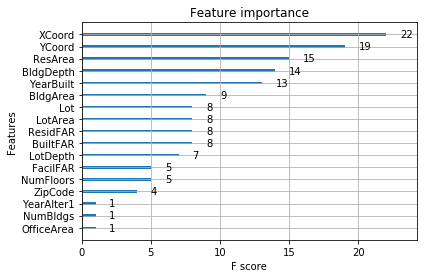

In [59]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(Xlog.drop(columns = ['Complaint','Address']),
                                                    Xlog[['Complaint']], test_size = 0.2, random_state=0)

dmTrain = xgb.DMatrix(x_train,label = y_train)
dmTest = xgb.DMatrix(x_test,label = y_test)

param = {'max_depth': 4, 'eta': 1, 'objective': 'binary:logistic', 'eval_metric':'logloss'}
num_round = 10
xgbModel = xgb.train(param, dmTrain, num_round, evals=[(dmTrain, 'Train'),(dmTest, 'Test')])
xgb.plot_importance(xgbModel)

[19:27:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[0]	Train-logloss:0.333112	Test-logloss:0.341017
[19:27:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[1]	Train-logloss:0.298957	Test-logloss:0.30988
[19:28:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[2]	Train-logloss:0.290504	Test-logloss:0.305262
[19:28:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[3]	Train-logloss:0.287816	Test-logloss:0.304285
[19:28:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[4]	Train-logloss:0.285601	Test-logloss:0.303189
[19:28:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[5]	Train-logloss:0.282961	Test-logloss:0.302997
[19:28:54] src/tree/updater_prune.c

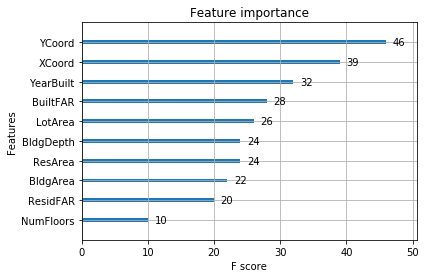

In [61]:
x_train, x_test, y_train, y_test = train_test_split(Xlog.drop(columns = ['Complaint','Address','ZipCode','Lot','YearAlter1','RetailArea',
                                                                         'LotDepth','NumBldgs','FacilFAR','CommFAR','OfficeArea']),
                                                    Xlog[['Complaint']], test_size = 0.2, random_state=0)

dmTrain = xgb.DMatrix(x_train,label = y_train)
dmTest = xgb.DMatrix(x_test,label = y_test)

param = {'max_depth': 5, 'eta': 1, 'objective': 'binary:logistic', 'eval_metric':'logloss'}
num_round = 10
xgbModel = xgb.train(param, dmTrain, num_round, evals=[(dmTrain, 'Train'),(dmTest, 'Test')])
xgb.plot_importance(xgbModel)
plt.show()